In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
path = 'data'
train_files = os.listdir(os.path.join(path, 'train_sample_videos'))
train_files.remove('metadata.json')
test_files = os.listdir(os.path.join(path, 'test_videos'))

print(f'Number of Train files: {len(train_files)}\nNumber of Test files: {len(test_files)}')

Number of Train files: 400
Number of Test files: 400


## Equal number of train and test samples

In [3]:
# reading the labels json file
labels_df = pd.read_json(os.path.join(path, 'train_sample_videos/metadata.json'))
labels_df = labels_df.T
print(labels_df.shape)
labels_df.head()

(400, 3)


,label,split,original
aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4
aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4
abarnvbtwb.mp4,REAL,train,None
abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4
abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4


In [26]:
import seaborn as sns
def plot_count(feature, title, df, size=1):
    '''
    Plot count of classes / feature
    param: feature - the feature to analyze
    param: title - title to add to the graph
    param: df - dataframe from which we plot feature's classes distribution 
    param: size - default 1.
    '''
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(df))
    g = sns.countplot(df[feature], order = df[feature].value_counts().index[:20], palette='Set3')
    g.set_title("Number and percentage of {}".format(title))
    if(size > 2):
        plt.xticks(rotation=90, size=8)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show()    

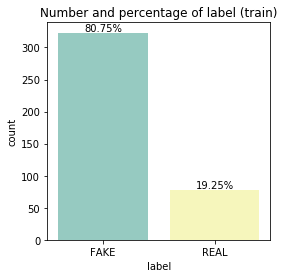

In [29]:
plot_count('label', 'label (train)', labels_df)

## Get info about frame size, FPS and duration

In [5]:
# gets the frame size for a video
def get_frame_size(file):
    cap = cv2.VideoCapture(file)
    ret, frame = cap.read()
    #plt.imshow(frame)
    shape = frame.shape
    cap.release()
    return shape

# gets the fps and duration of video
def get_video_length(file):
    cap = cv2.VideoCapture(file)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = frame_count/fps
    cap.release()
    return round(fps), round(duration)

# extract metadata of all files and return in a dataframe
def extract_metadata(files, path):
    frame_size_list = []
    fps_list = []
    duration_list = []
    for i in tqdm(files):
        shape = get_frame_size(os.path.join(path,f'{i}'))
        fps, duration = get_video_length(os.path.join(path,f'{i}'))
        frame_size_list.append(shape)
        fps_list.append(fps)
        duration_list.append(duration)

    meta_df = pd.DataFrame(data={'frame_shape':frame_size_list, 'fps':fps_list, 'duration':duration_list}, index=files)
    return meta_df

print(get_frame_size(os.path.join(path, 'train_sample_videos/aagfhgtpmv.mp4')))
print(get_video_length(os.path.join(path, 'train_sample_videos/aagfhgtpmv.mp4')))

(1080, 1920, 3)
(30, 10)


In [6]:
# getting metadata for train files
train_meta = extract_metadata(train_files, os.path.join(path, 'train_sample_videos'))
train_meta.head()

100%|██████████| 400/400 [00:17<00:00, 23.88it/s]


,frame_shape,fps,duration
dsgpbgsrdm.mp4,"(1080, 1920, 3)",30,10
dsjbknkujw.mp4,"(1080, 1920, 3)",30,10
dnyvfblxpm.mp4,"(1080, 1920, 3)",30,10
dbhrpizyeq.mp4,"(1920, 1080, 3)",30,10
andaxzscny.mp4,"(1080, 1920, 3)",30,10


In [7]:
train_meta.frame_shape.value_counts()

(1080, 1920, 3)    375
(1920, 1080, 3)     25
Name: frame_shape, dtype: int64

In [8]:
train_meta.fps.value_counts()

30    400
Name: fps, dtype: int64

In [9]:
print('Duration in seconds')
print(train_meta.duration.value_counts())

Duration in seconds
10    400
Name: duration, dtype: int64


In [10]:
# getting metadata for test files
test_meta = extract_metadata(test_files, os.path.join(path, 'test_videos'))
test_meta.head()

100%|██████████| 400/400 [00:17<00:00, 22.22it/s]


,frame_shape,fps,duration
qooxnxqqjb.mp4,"(1080, 1920, 3)",30,10
hfsvqabzfq.mp4,"(1080, 1920, 3)",30,10
heiyoojifp.mp4,"(1920, 1080, 3)",30,10
fnxgqcvlsd.mp4,"(1080, 1920, 3)",30,10
hitfycdavv.mp4,"(1920, 1080, 3)",30,10


In [11]:
test_meta.frame_shape.value_counts()

(1080, 1920, 3)    326
(1920, 1080, 3)     74
Name: frame_shape, dtype: int64

In [12]:
test_meta.fps.value_counts()

30    400
Name: fps, dtype: int64

In [13]:
test_meta.duration.value_counts()

10    400
Name: duration, dtype: int64

* All videos are of 10 seconds and in 30 fps
* Videos are in 2 frame sizes:
  * 1080 X 1920
  * 1920 X 1080

In [14]:
submission = pd.read_csv(f"{path}/sample_submission.csv")
submission.head()

,filename,label
0,aassnaulhq.mp4,0
1,aayfryxljh.mp4,0
2,acazlolrpz.mp4,0
3,adohdulfwb.mp4,0
4,ahjnxtiamx.mp4,0


## Check missing data

In [16]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [17]:
missing_data(labels_df)

,label,split,original
Total,0,0,77
Percent,0,0,19.25
Types,object,object,object


In [20]:
missing_data(labels_df.loc[labels_df.label=='REAL'])

,label,split,original
Total,0,0,77
Percent,0,0,100
Types,object,object,object


All missing `original` data are the one associated with `REAL` label.  